In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error


ModuleNotFoundError: No module named 'seaborn'

In [2]:
df = pd.read_csv(r"C:\Users\Radha\Downloads\uber.csv")
print("Initial shape:", df.shape)


Initial shape: (200000, 9)


In [3]:
# Remove missing/null values
df = df.dropna()
print("After Removing Null Values:", df.shape)

# Remove invalid fare & passenger values
df = df[(df.fare_amount > 0) & (df.fare_amount < 100)]
df = df[(df.passenger_count > 0) & (df.passenger_count <= 6)]
print("After Removing Invalid Values:", df.shape)

# Create Distance Feature (Simple Approx)
df["distance"] = np.sqrt((df["pickup_latitude"] - df["dropoff_latitude"])**2 +
                         (df["pickup_longitude"] - df["dropoff_longitude"])**2)

# Remove unrealistic distances
df = df[(df["distance"] > 0) & (df["distance"] < 5)]
print("After Distance Filtering:", df.shape)
print(df.head())
print(df.iloc[37:41])
print(df.iloc[37:41].index)

df.reset_index(drop=True, inplace=True)

print(df.iloc[37:41])


After Removing Null Values: (199999, 9)
After Removing Invalid Values: (199178, 9)
After Distance Filtering: (193148, 10)
   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  distance  
0         -73.999512         40.723217              

In [4]:
# ==========================================================
# 2. IDENTIFY OUTLIERS (Using IQR Method)
# ==========================================================
Q1 = df["fare_amount"].quantile(0.25)
Q3 = df["fare_amount"].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df["fare_amount"] < (Q1 - 1.5*IQR)) | (df["fare_amount"] > (Q3 + 1.5*IQR))]
print("\nNumber of Outliers in Fare Amount:", outliers.shape[0])



Number of Outliers in Fare Amount: 16470



Correlation Matrix:

                 fare_amount  passenger_count  distance
fare_amount         1.000000         0.013794  0.780522
passenger_count     0.013794         1.000000  0.005465
distance            0.780522         0.005465  1.000000


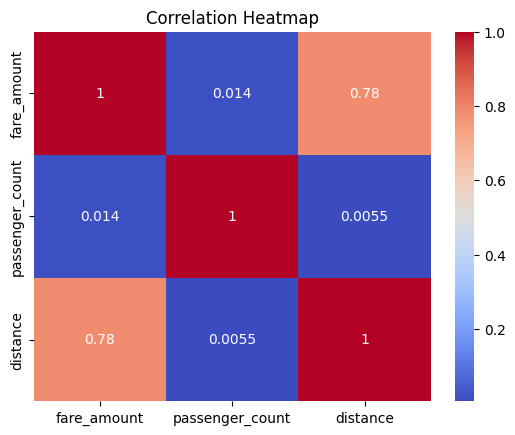

In [5]:
# 3. CHECK CORRELATION
# ==========================================================
print("\nCorrelation Matrix:\n")
print(df[["fare_amount", "passenger_count", "distance"]].corr())

sns.heatmap(df[["fare_amount","passenger_count","distance"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# FEATURES & TARGET
# ==========================================================
X = df[['passenger_count', 'distance']]
y = df['fare_amount']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


In [6]:
#4. IMPLEMENT MODELS
# ==========================================================

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest Regression
rf = RandomForestRegressor(n_estimators=100, random_state=10)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)




Model Performance:

Linear Regression -> R2 Score: 0.660, RMSE: 5.396
Random Forest Regression -> R2 Score: 0.739, RMSE: 4.730

Linear Regression - Actual vs Predicted:

   Actual  Predicted (LR)
0    4.10        7.198910
1   25.54       14.896171
2   10.10       13.239341
3    8.00        8.899630
4   57.33       44.697089
5    6.10        7.413909
6    5.30        8.537383
7   15.00       14.263644
8    7.30        9.015040
9    3.70        6.548913

Random Forest - Actual vs Predicted:

   Actual  Predicted (RF)
0    4.10        4.709000
1   25.54       15.287000
2   10.10       19.367500
3    8.00        7.184000
4   57.33       68.924000
5    6.10        5.588933
6    5.30       10.046000
7   15.00       16.771000
8    7.30        8.534000
9    3.70        3.880000


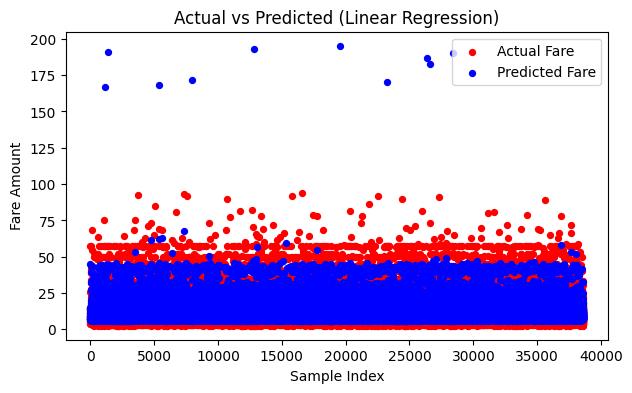

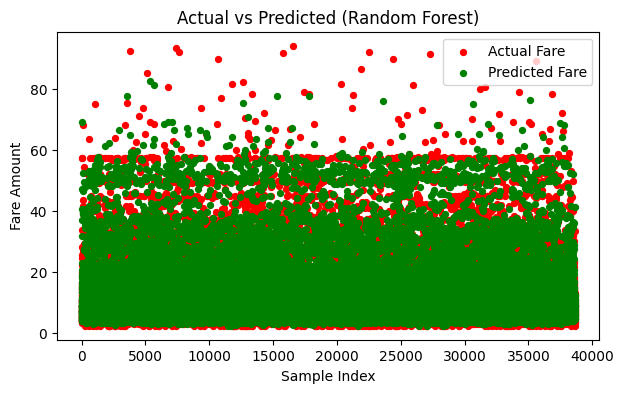

In [7]:
# 5. MODEL EVALUATION & COMPARISON
# ==========================================================
def evaluate(model_name, y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{model_name} -> R2 Score: {r2:.3f}, RMSE: {rmse:.3f}")

print("\nModel Performance:\n")
evaluate("Linear Regression", y_test, y_pred_lr)
evaluate("Random Forest Regression", y_test, y_pred_rf)

comparison_lr = pd.DataFrame({"Actual": y_test.values, "Predicted (LR)": y_pred_lr})
comparison_rf = pd.DataFrame({"Actual": y_test.values, "Predicted (RF)": y_pred_rf})

print("\nLinear Regression - Actual vs Predicted:\n")
print(comparison_lr.head(10))

print("\nRandom Forest - Actual vs Predicted:\n")
print(comparison_rf.head(10))

# Plot for Linear Regression
plt.figure(figsize=(7,4))
plt.scatter(range(len(y_test)), y_test, color='red', label='Actual Fare', s=18)
plt.scatter(range(len(y_test)), y_pred_lr, color='blue', label='Predicted Fare', s=18)
plt.xlabel("Sample Index")
plt.ylabel("Fare Amount")
plt.title("Actual vs Predicted (Linear Regression)")
plt.legend()
plt.show()

# Plot for Random Forest Regression
plt.figure(figsize=(7,4))
plt.scatter(range(len(y_test)), y_test, color='red', label='Actual Fare', s=18)
plt.scatter(range(len(y_test)), y_pred_rf, color='green', label='Predicted Fare', s=18)
plt.xlabel("Sample Index")
plt.ylabel("Fare Amount")
plt.title("Actual vs Predicted (Random Forest)")
plt.legend()
plt.show()
